In [1]:
import pandas as pd
import pandas_gbq
import pydata_google_auth
import numpy as np
import matplotlib.pyplot as plt
import math
import calendar
from uniswap_data import Uniswap_Pool
from tqdm import tqdm
from datetime import timedelta
from functools import reduce

In [2]:
%run "/Users/amyoumaymakhaldoun/Desktop/Panoptic/backtester_functions.ipynb"
plt.style.use('panoptic-dark-16_9.mplstyle')   


In [3]:
def calc_DTE(r: float, volatility: float = 1) -> float:
    """Calculates corresponding options DTE for a UniV3 range factor"""
    return 365 * (2 * np.pi / volatility ** 2) * ( (np.sqrt(r) - 1) / (np.sqrt(r) + 1) ) ** 2

for r in [1.05, 1.25, 1.6]:
    print(f"A range factor of {r} corresponds to {calc_DTE(r)} days")

A range factor of 1.05 corresponds to 0.34117267002011364 days
A range factor of 1.25 corresponds to 7.122312907820098 days
A range factor of 1.6 corresponds to 31.374052602292934 days


In [4]:
init_start = '2024-01-01'
init_end = '2024-02-28'

In [5]:
# Get the price of the pool:
# Parameters for the Uniswap pool
token_0 = 'USDC'  # Stablecoin for example
token_1 = 'ETH'   # Ethereum for example
fee = 30     # 5 bps fee or 1, 30 or 100 
start = init_start  # Start in string
end = init_end    # End in string
window = 60 * 60 * 24  # 1 day window
inverse_price = True   # If True, price in terms of token_0 (USDC/ETH), else ETH/USDC
# Initialize the Uniswap Pool object
pool_data = Uniswap_Pool(token_0, token_1, fee, start, end, window, inverse_price)
eth_prices = pool_data.data['price']  

# Load data (data is fetched inside Uniswap_Pool class)
print("Data loaded successfully!")

Loading Data...
Downloading: 100%|██████████|
Data loaded successfully!


In [6]:
eth_prices

timestamp
2024-01-01 00:03:35+00:00    2278.371220
2024-01-01 00:04:11+00:00    2279.738585
2024-01-01 00:05:23+00:00    2280.878682
2024-01-01 00:05:35+00:00    2282.019350
2024-01-01 00:06:23+00:00    2283.160587
                                ...     
2024-02-27 23:12:23+00:00    3250.611205
2024-02-27 23:48:59+00:00    3250.611205
2024-02-27 23:50:35+00:00    3250.611205
2024-02-27 23:52:11+00:00    3250.286177
2024-02-27 23:52:11+00:00    3250.286177
Name: price, Length: 17349, dtype: float64

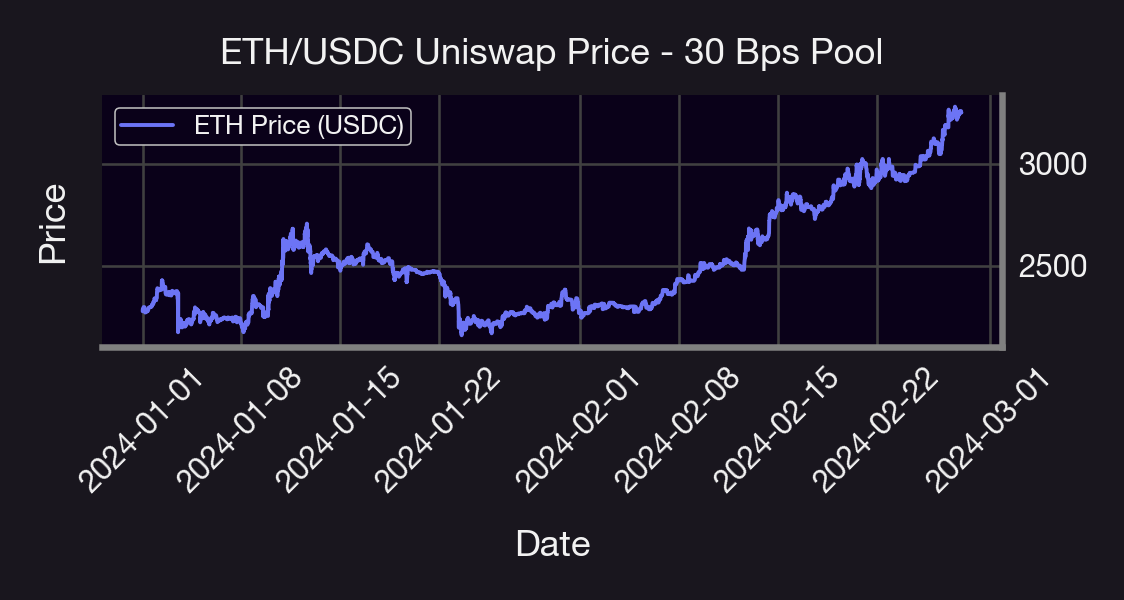

In [7]:
#plot the ETH prices over time
plt.plot(eth_prices, label='ETH Price (USDC)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('ETH/USDC Uniswap Price - 30 Bps Pool')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [8]:
# Create as many strategies as you want!
local_dir = '/Users/amyoumaymakhaldoun/Desktop/Panoptic graphs' # notebook will save a bazillion (ok...<100) graphs/spreadsheets under this directory so be careful!
# Alternatively you can comment out code for plots you don't care about
# Or comment out plt.savefig(dir)!

'''strat_1 = LP_Rebalance(
            token_0 = 'USDC',
            token_1 = 'ETH',
            fee = 30,
            local_dir = local_dir,
            start_t = '2025-01-01',
            end_t = '2025-02-01',
            range_perc = 27, # r = 1.25
            col_ratio = 100, # fully-collateralized
            com_ratio = 0, # no commission
            PLP_annual_yield = 0, # no PLP yield
            spread_mult = 1, # no spread multipilier
            pool_data = None,
            inverse_price = True,
            legs = {'SHORT_CALL': 1},
            delta = {'SHORT_CALL': -0.5}
)'''

# Strategy 1: Covered Call
strat_1 = LP_Rebalance(
    token_0 = 'USDC',
    token_1 = 'ETH',
    fee = 30,
    local_dir = local_dir,
    start_t = init_start,
    end_t = init_end,
    range_perc = 25,  # r = 1.25
    com_ratio = 0, # no commission
    PLP_annual_yield = 0, # no PLP yield
    col_ratio = 100,  # fully-collateralized
    spread_mult = 1, # no spread multipilier
    inverse_price = True,
    legs = {'SHORT_CALL': 1},
    delta = {'SHORT_CALL': -0.3}  # Slightly OTM call
)

# Strategy 2: Protective Put
strat_2 = LP_Rebalance(
    token_0 = 'USDC',
    token_1 = 'ETH',
    fee = 30,
    local_dir = local_dir,
    start_t = init_start,
    end_t = init_end,
    range_perc = 25,
    col_ratio = 100,
    PLP_annual_yield = 0, # no PLP yield
    spread_mult = 1, # no spread multipilier
    inverse_price = True,
    legs = {'LONG_PUT': 1},
    delta = {'LONG_PUT': -0.3}  # Slightly OTM put
)

# Set strategies to compare and run them
strategies = {
    strat_1: ('m'),  # Monthly rebalancing
    strat_2: ('m')   # Monthly rebalancing
}
'''
Choose strategy rebalancing periods that you want to plot.
You can update these later without having to re-run the strategies.

'a' = all (daily, weekly, and monthly)
'd' = daily
'w' = weekly
'm' = monthly
'''
'''strategies = {strat_1: ('m'),
            #   strat_2: ('w'),
            #   strat_3: ('m'),
             }'''

[x.run_strat() for x in strategies]


Loading Data...
Downloading: 100%|██████████|
Loading Data...
Downloading: 100%|██████████|


/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_41283/4139823987.py:277: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  daily['price_start'] = daily.groupby('date')['price_lag'].transform(lambda x: x[0])
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_41283/4139823987.py:278: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  daily['tick_start'] = daily.groupby('date')['tick_lag'].transform(lambda x: x[0])
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_41283/4139823987.py:279: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will

Running Strategy


0it [00:00, ?it/s]
Step 1: 100%|██████████| 17348/17348 [00:00<00:00, 170924.63it/s]
0it [00:00, ?it/s]
Step 2: 100%|██████████| 17348/17348 [00:01<00:00, 13844.00it/s]
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_41283/4139823987.py:401: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price_close = df['price'][-1]
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_41283/4139823987.py:402: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sqrtPrice_close = df['sqrtPrice'][-1]
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_41283/4139823987.py:160: DeprecationWarning: DataFrameGroupBy.apply 

Running Strategy


0it [00:00, ?it/s]
Step 1: 100%|██████████| 17348/17348 [00:00<00:00, 172590.94it/s]
0it [00:00, ?it/s]
Step 2: 100%|██████████| 17348/17348 [00:01<00:00, 12435.60it/s]
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_41283/4139823987.py:401: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price_close = df['price'][-1]
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_41283/4139823987.py:402: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sqrtPrice_close = df['sqrtPrice'][-1]
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_41283/4139823987.py:160: DeprecationWarning: DataFrameGroupBy.apply 

[None, None]

In [9]:
pool_strategy = 'Short Calls vs. Long Puts'
reb_period = 'Weekly'

pool_name_2 = 'ETH Options Strategies (ETH-USDC 30bps)'
subtitle = 'Income Generation vs. Downside Protection'



In [10]:
for strat, period in strategies.items():
    print(strat.legs)

{'SHORT_CALL': 1}
{'LONG_PUT': 1}


In [11]:
legs_dict = strat.legs

In [12]:
strategies

{<__main__.LP_Rebalance at 0x16c20dc50>: 'm',
 <__main__.LP_Rebalance at 0x16c0a3490>: 'm'}

/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_41283/3372179955.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i % len(colors)])
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_41283/3372179955.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cum_rets[-1] + y_offset,
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_41283/3372179955.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent w

Short Call
Long Put


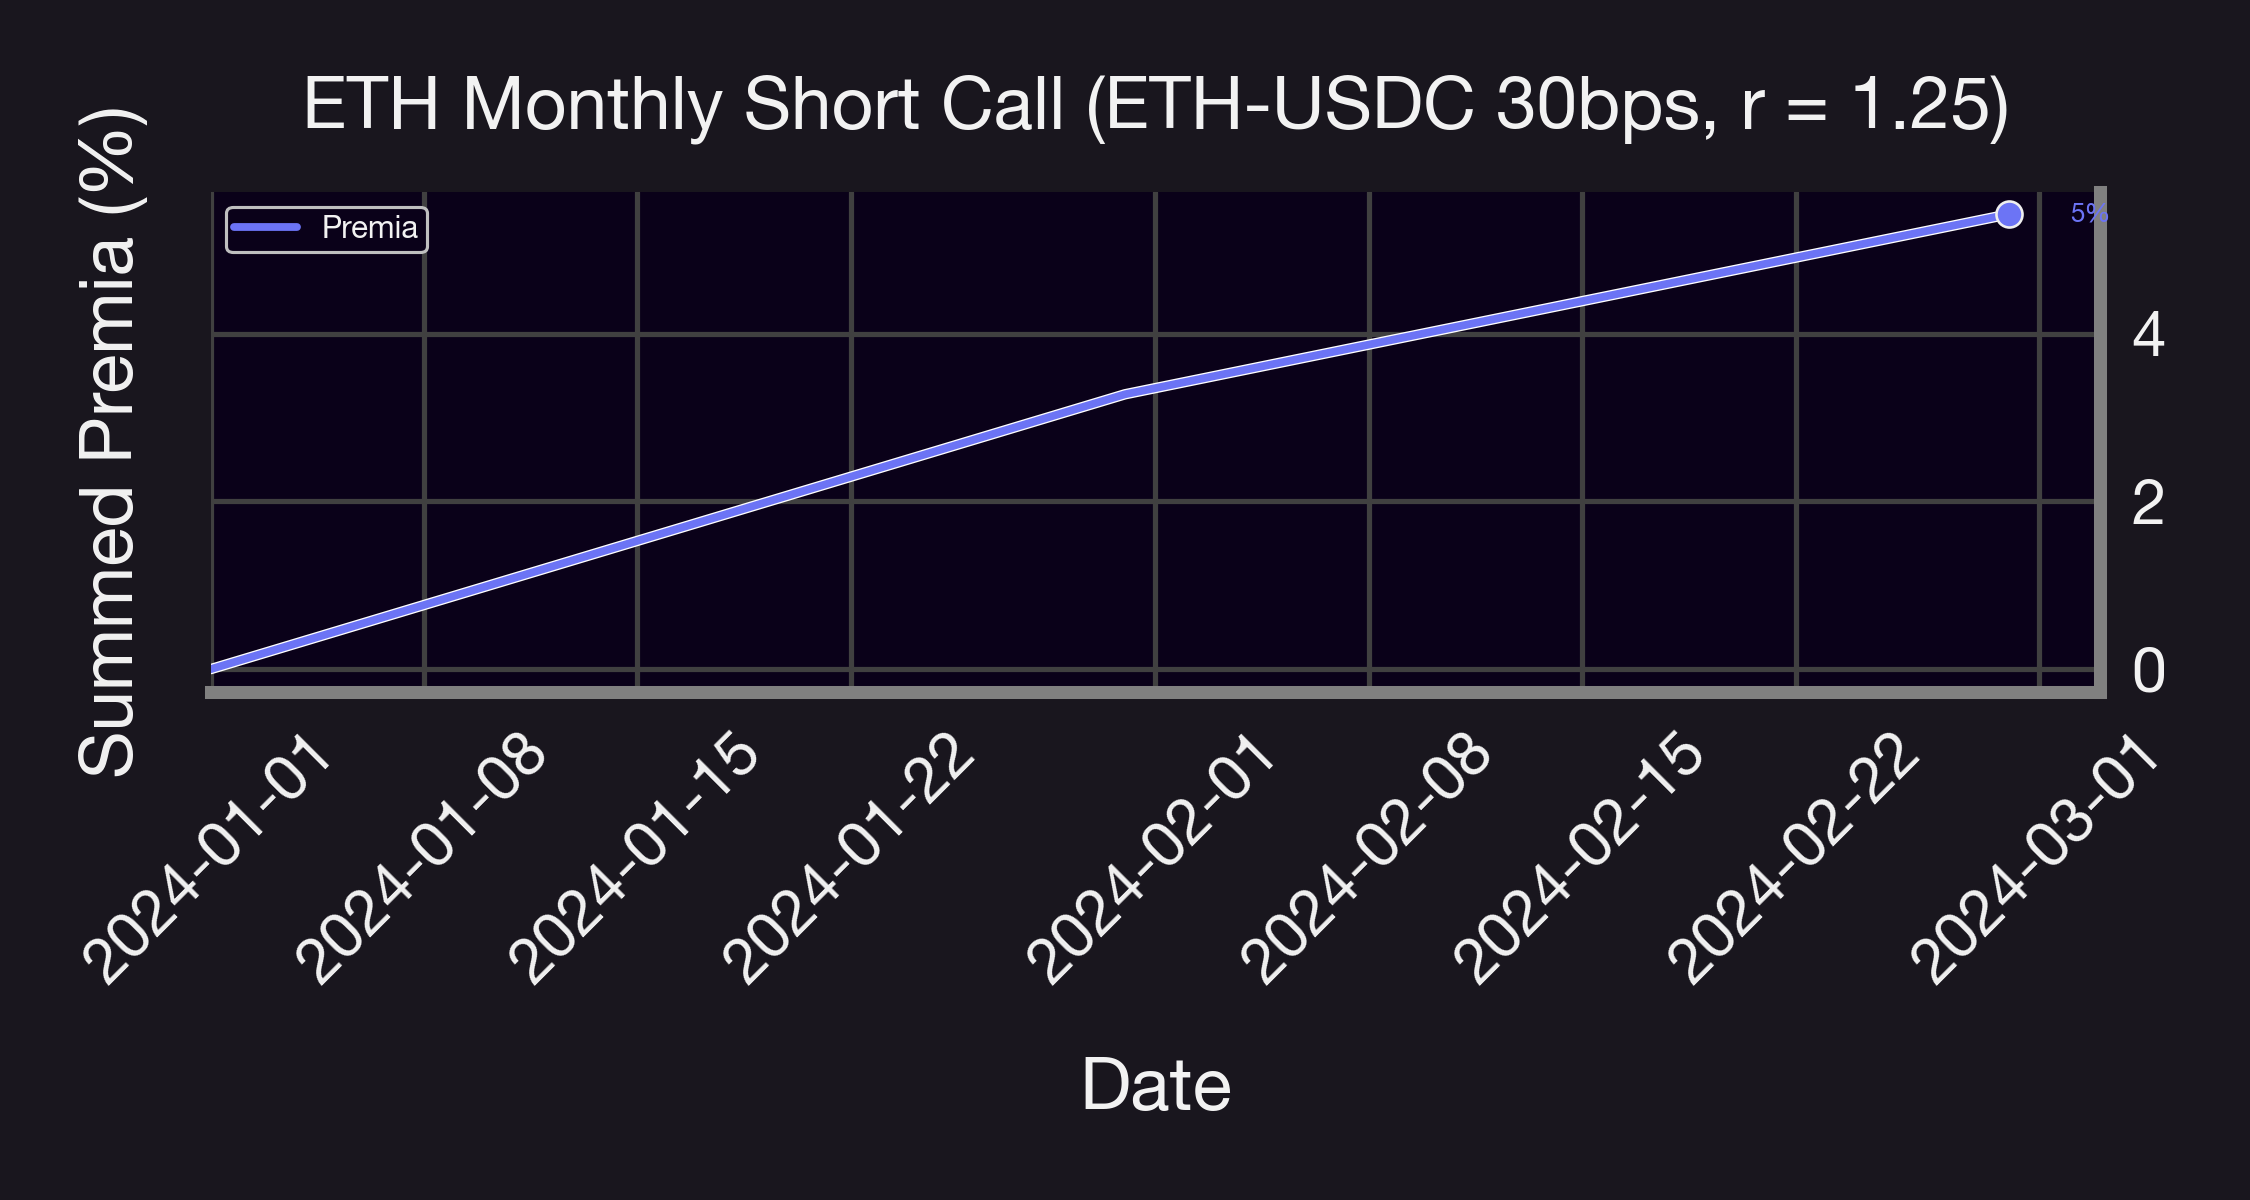

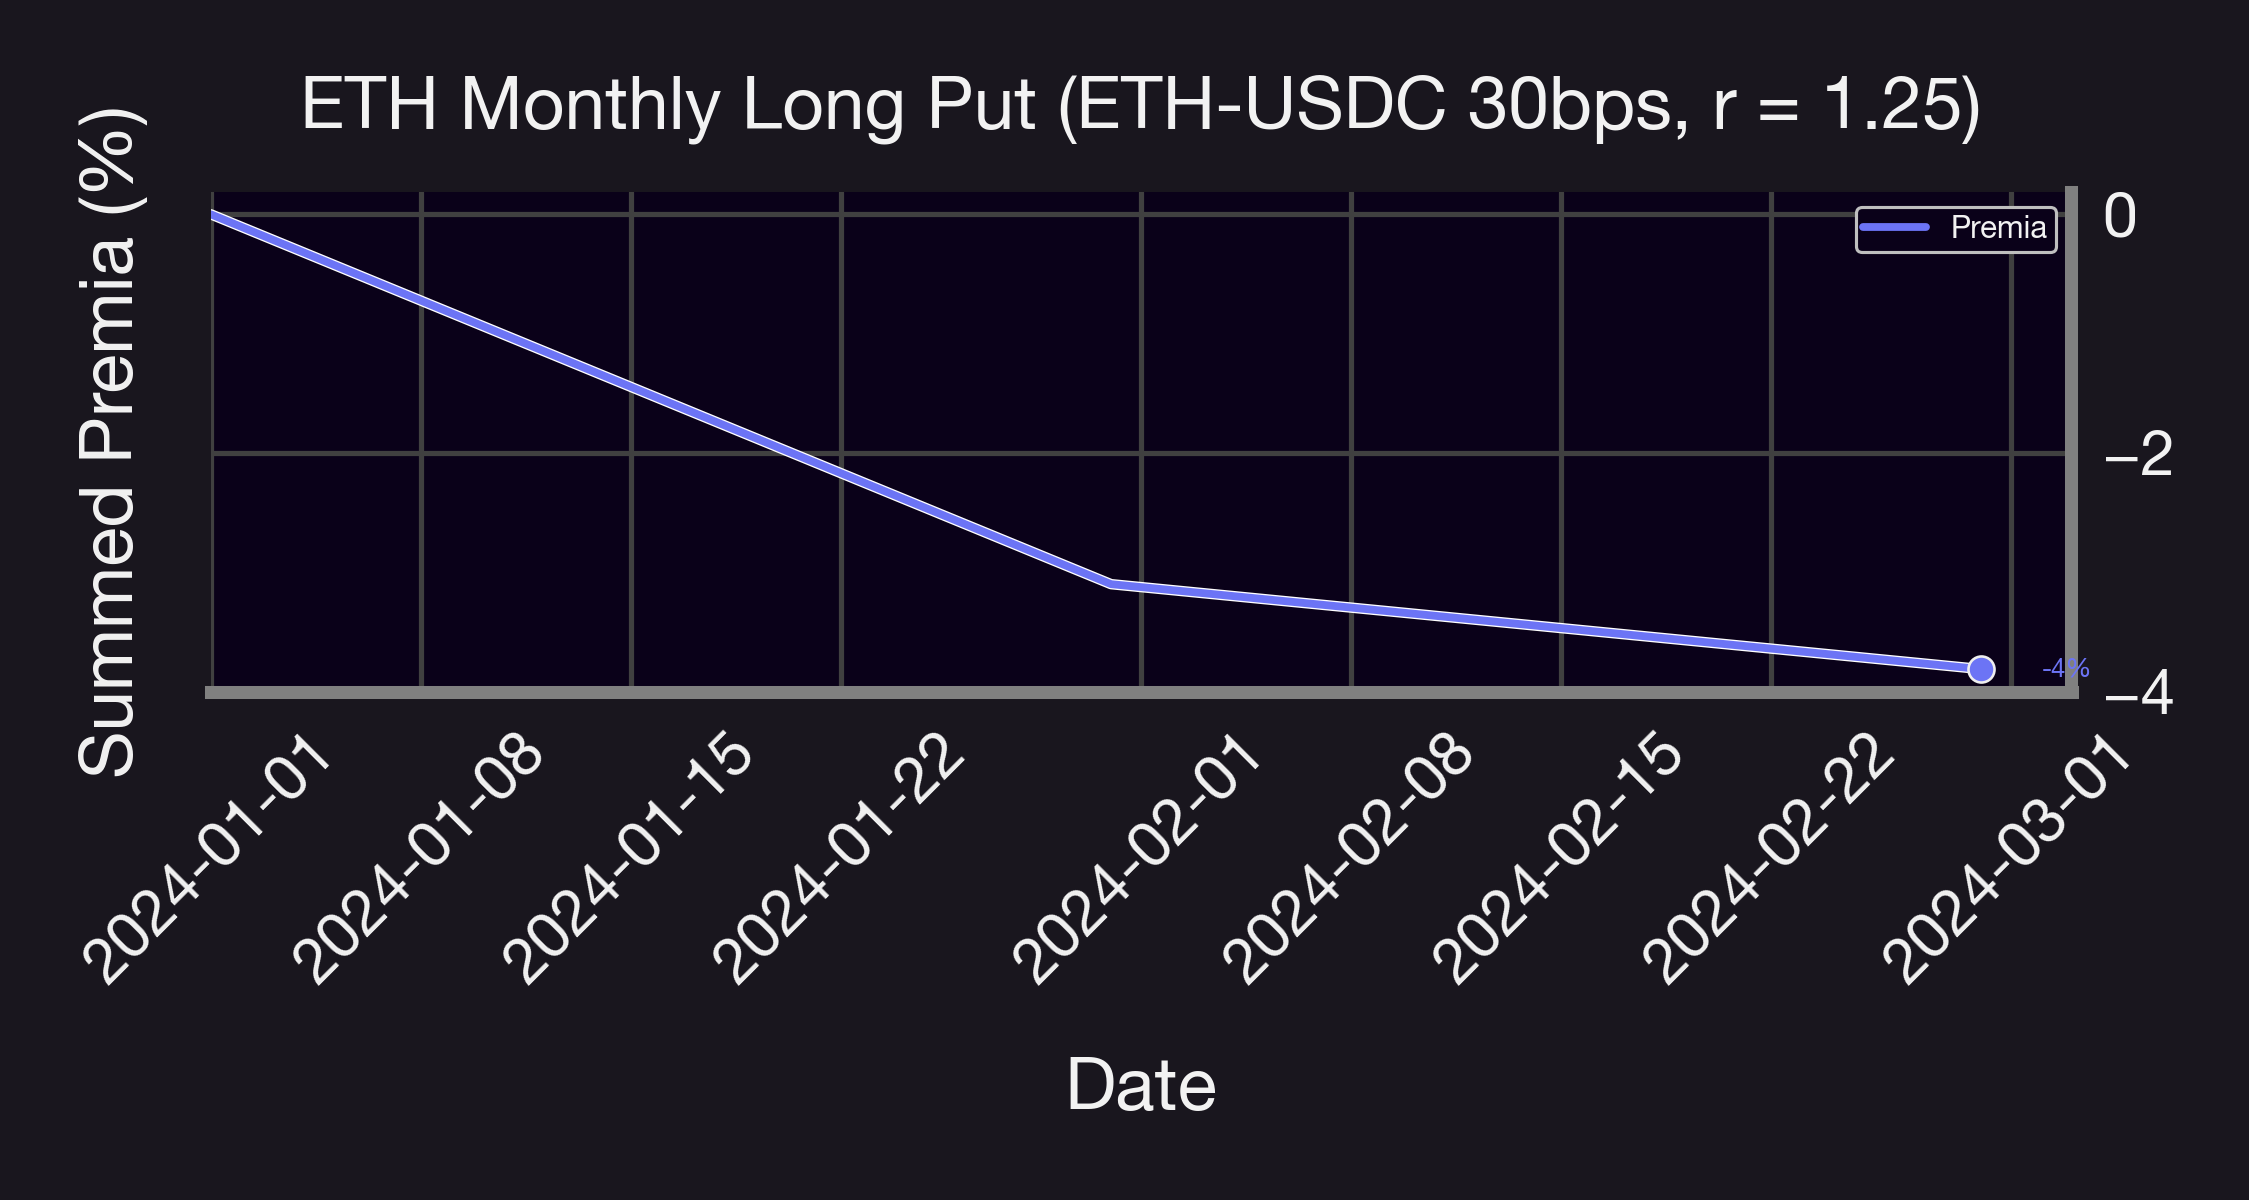

In [13]:
'''Summed Returns'''
rets = {}
for strat, period in strategies.items():
          # Extract the strategy name from the legs dictionary
     legs_dict = strat.legs
     strategy_key = list(legs_dict.keys())[0]  # Get the first key
     strategy_name = strategy_key.replace('_', ' ').title()
     print(strategy_name)

     if 'a' in period or 'd' in period:
          rets['Premia'] = strat.daily_fees['fees_perc']
          rets['Payoff'] = strat.daily_pos['pnl_perc']
          # rets['Commissions'] = strat.daily_com['coms_perc']
          # rets['PLP_yield'] = strat.daily_PLP_yield['PLP_yield_perc']
          rets['Return'] = strat.daily_pos['pnl_perc'] \
                              + strat.daily_fees['fees_perc'] \
                              - strat.daily_com['coms_perc'] \
                              + strat.daily_PLP_yield['PLP_yield_perc']
          period_label = 'Daily'
          period_name = 'Dailies'
     if 'a' in period or 'w' in period:
          rets['Premia'] = strat.weekly_fees['fees_perc']
          rets['Payoff'] = strat.weekly_pos['pnl_perc']
          # rets['Commissions'] = strat.daily_com['coms_perc']
          # rets['PLP_yield'] = strat.weekly_PLP_yield['PLP_yield_perc']
          rets['Return'] = strat.weekly_pos['pnl_perc'] \
                              + strat.weekly_fees['fees_perc'] \
                              - strat.weekly_com['coms_perc'] \
                              + strat.weekly_PLP_yield['PLP_yield_perc']
          period_label = 'Weekly'
          period_name = 'Weeklies'
     if 'a' in period or 'm' in period:
          rets['Premia'] = strat.monthly_fees['fees_perc']
        #   rets['Payoff'] = strat.monthly_pos['pnl_perc']
        #   # rets['Commissions'] = strat.daily_com['coms_perc']
        #   # rets['PLP_yield'] = strat.monthly_PLP_yield['PLP_yield_perc']
        #   rets['Return'] = strat.monthly_pos['pnl_perc'] \
        #                       + strat.monthly_fees['fees_perc'] \
        #                       - strat.monthly_com['coms_perc'] \
        #                       + strat.monthly_PLP_yield['PLP_yield_perc']
          period_label = 'Monthly'
          period_name = 'Monthlies'

     # Plot rebalancing strategies
     plot_summed_rets(rets = rets,
          xlabel = 'Date',
          ylabel = 'Summed Premia (%)',
          title = f'ETH {period_label } {strategy_name} (ETH-USDC 30bps, {strat_label_2(strat)})',
          dir = f"{strat.raw_dir}{strat_label(strat, period_label)}"
     )

In [14]:
pool_name = 'Short Calls vs. Long Puts'
reb_period = 'Weekly'

pool_name_2 = 'ETH Options Strategies (ETH-USDC 30bps)'
subtitle = 'Income Generation vs. Downside Protection'

strategies = {
    strat_1: ('w'),  # Short Calls with ... rebalancing
    strat_2: ('w'),  # Long Puts with ... rebalancing
}

Short Call
Long Put


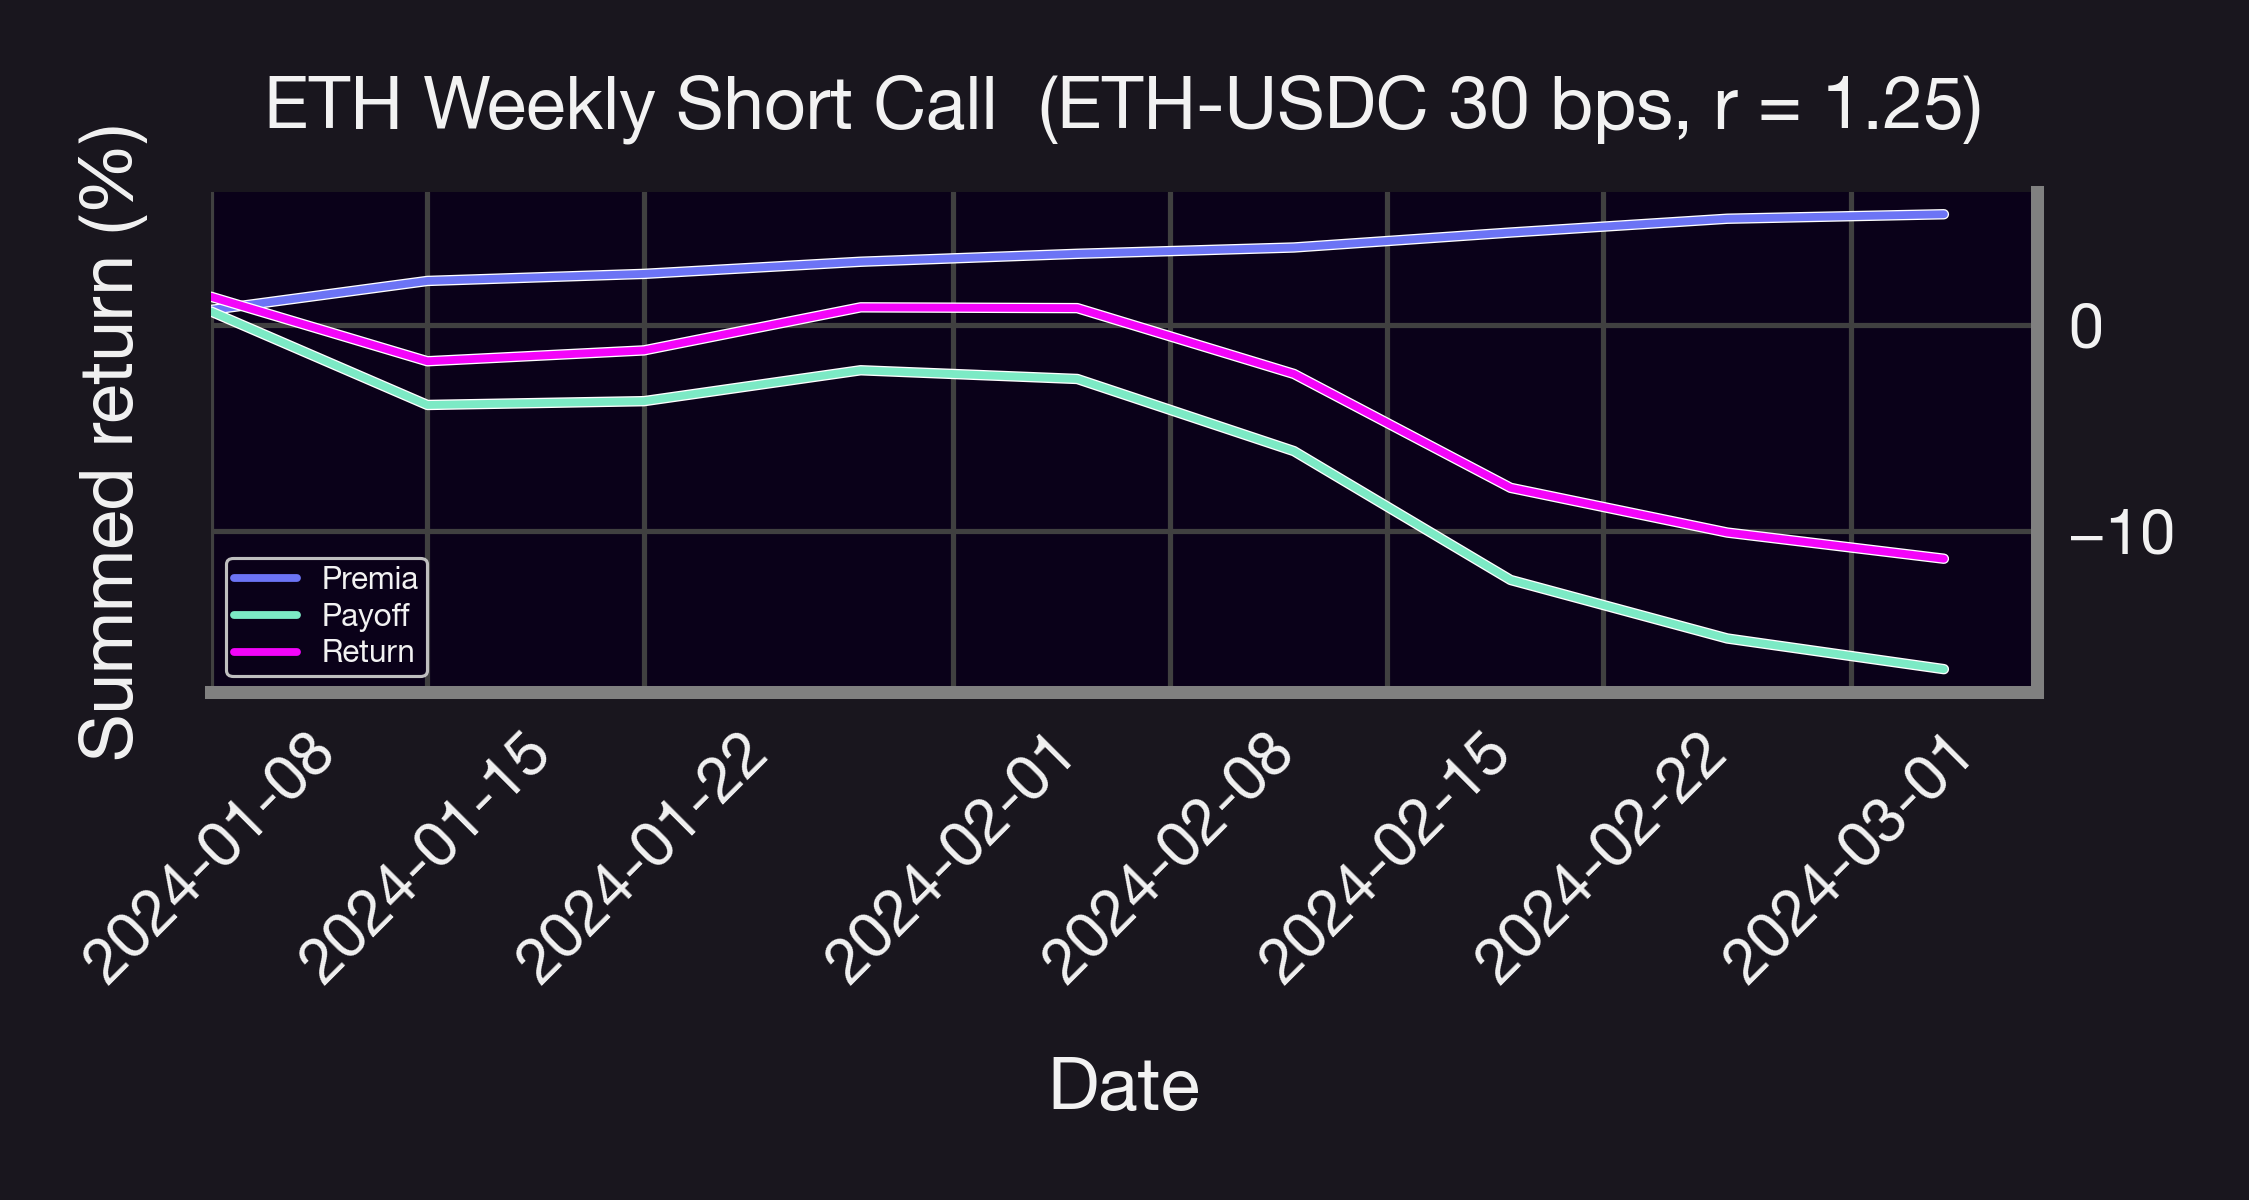

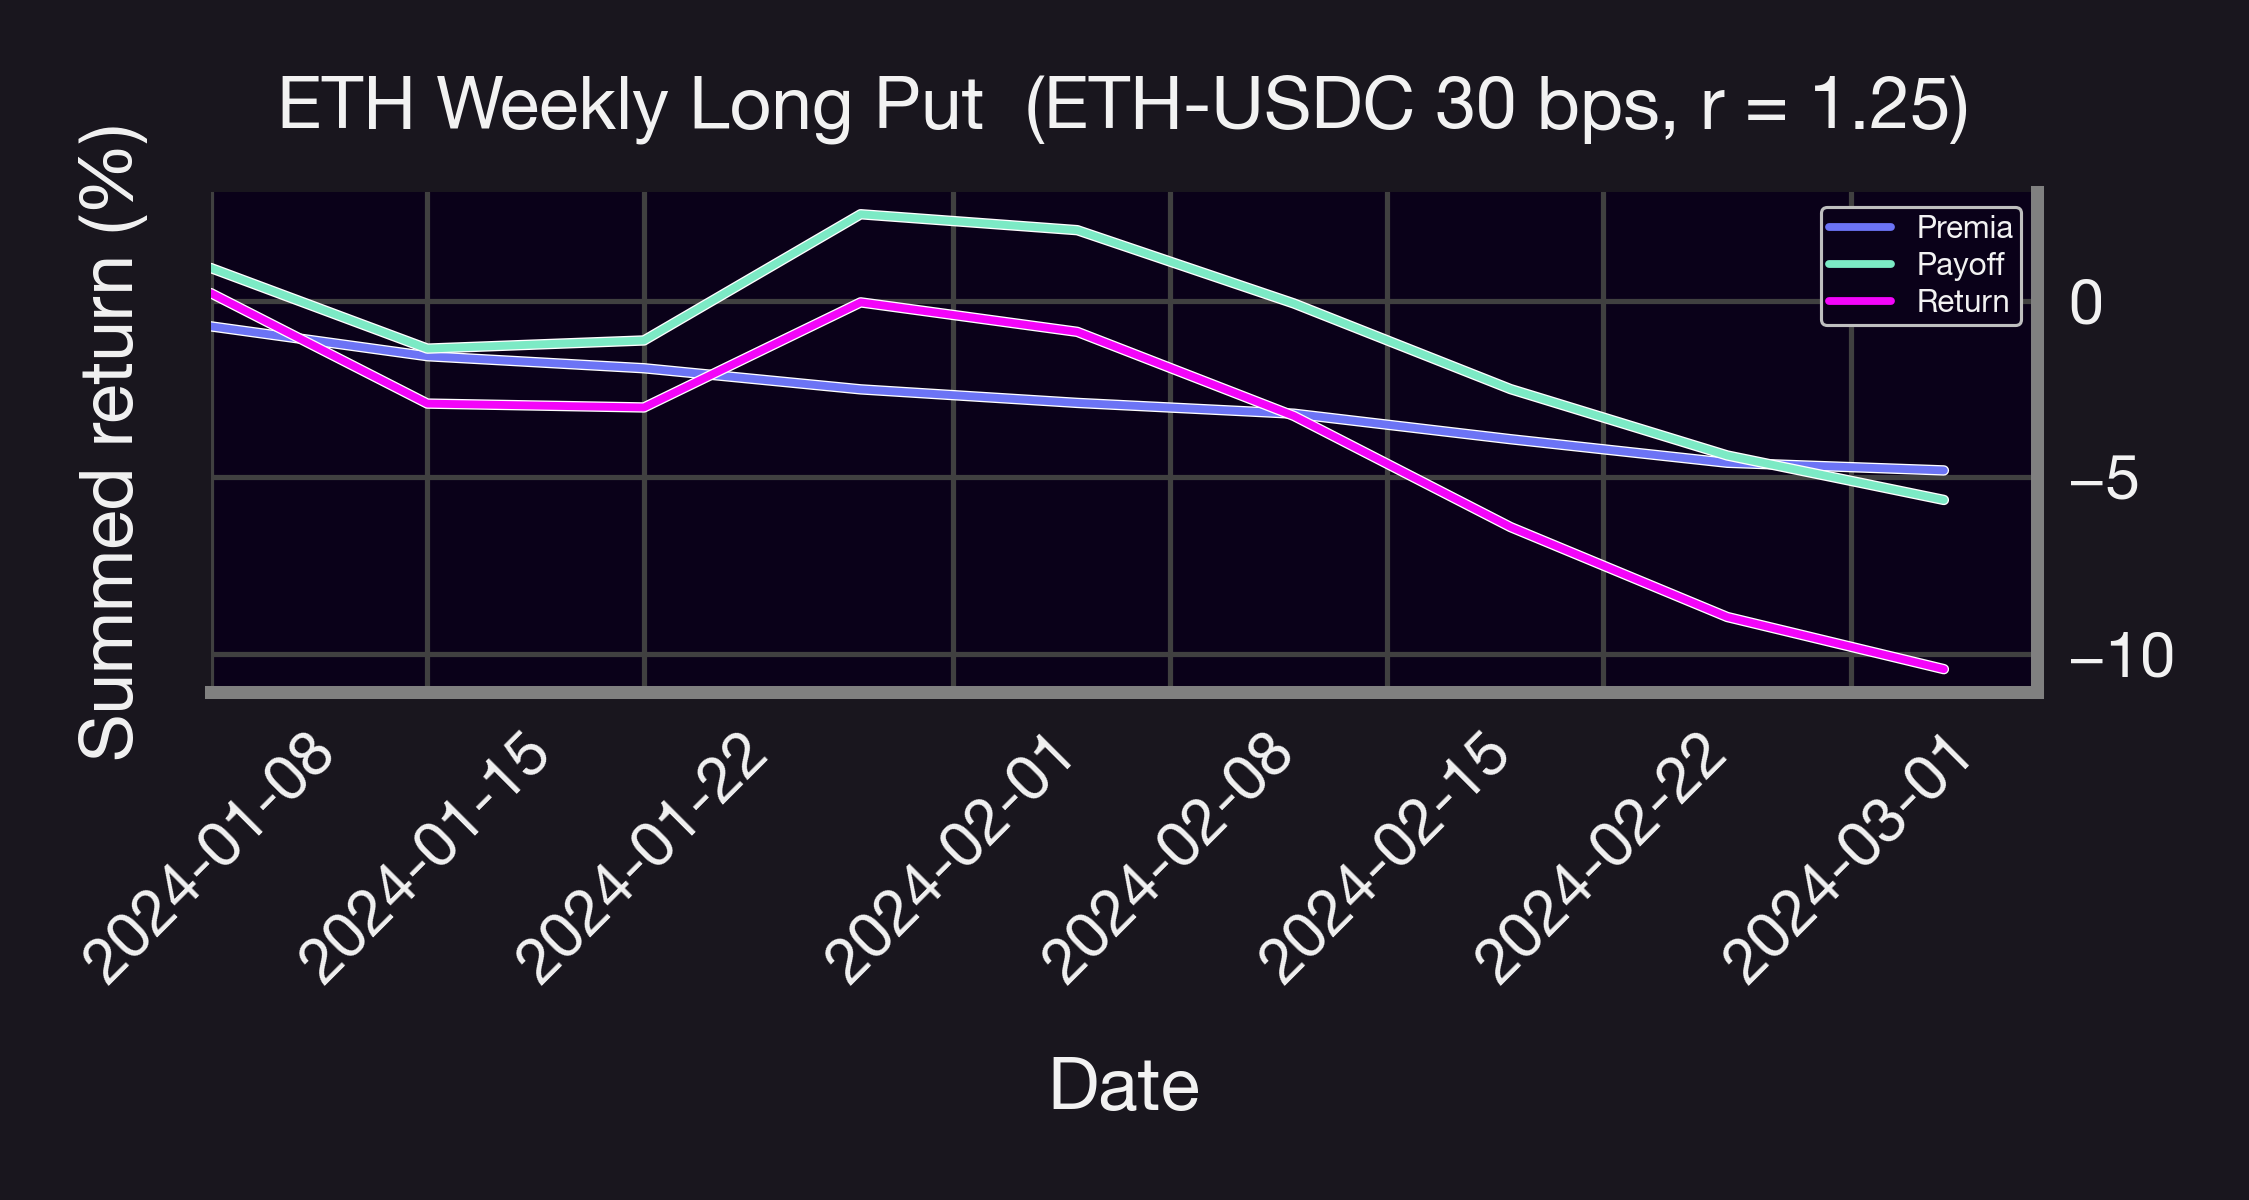

In [15]:
'''Summed Returns'''
rets = {}
for strat, period in strategies.items():
     legs_dict = strat.legs
     strategy_key = list(legs_dict.keys())[0]  # Get the first key
     strategy_name = strategy_key.replace('_', ' ').title()
     print(strategy_name)
     if 'a' in period or 'd' in period:
          rets['Premia'] = strat.daily_fees['fees_perc']
          rets['Payoff'] = strat.daily_pos['pnl_perc']
          # rets['Commissions'] = strat.daily_com['coms_perc']
          # rets['PLP_yield'] = strat.daily_PLP_yield['PLP_yield_perc']
          rets['Return'] = strat.daily_pos['pnl_perc'] \
                              + strat.daily_fees['fees_perc'] \
                              - strat.daily_com['coms_perc'] \
                              + strat.daily_PLP_yield['PLP_yield_perc']
          period_label = 'Daily'
          period_name = 'Dailies'
     if 'a' in period or 'w' in period:
          rets['Premia'] = strat.weekly_fees['fees_perc']
          rets['Payoff'] = strat.weekly_pos['pnl_perc']
          # rets['Commissions'] = strat.daily_com['coms_perc']
          # rets['PLP_yield'] = strat.weekly_PLP_yield['PLP_yield_perc']
          rets['Return'] = strat.weekly_pos['pnl_perc'] \
                              + strat.weekly_fees['fees_perc'] \
                              - strat.weekly_com['coms_perc'] \
                              + strat.weekly_PLP_yield['PLP_yield_perc']
          period_label = 'Weekly'
          period_name = 'Weeklies'
     if 'a' in period or 'm' in period:
          rets['Premia'] = strat.monthly_fees['fees_perc']
          rets['Payoff'] = strat.monthly_pos['pnl_perc']
          # rets['Commissions'] = strat.daily_com['coms_perc']
          # rets['PLP_yield'] = strat.monthly_PLP_yield['PLP_yield_perc']
          rets['Return'] = strat.monthly_pos['pnl_perc'] \
                              + strat.monthly_fees['fees_perc'] \
                              - strat.monthly_com['coms_perc'] \
                              + strat.monthly_PLP_yield['PLP_yield_perc']
          period_label = 'Monthly'
          period_name = 'Monthlies'

     # Plot rebalancing strategies
     plot_summed_rets(rets = rets,
          xlabel = 'Date',
          ylabel = 'Summed return (%)',
          title = f'ETH {period_label} {strategy_name}  (ETH-USDC 30 bps, {strat_label_2(strat)})',
          dir = f"{strat.raw_dir}{strat_label(strat, period_label)}", label=False
     )


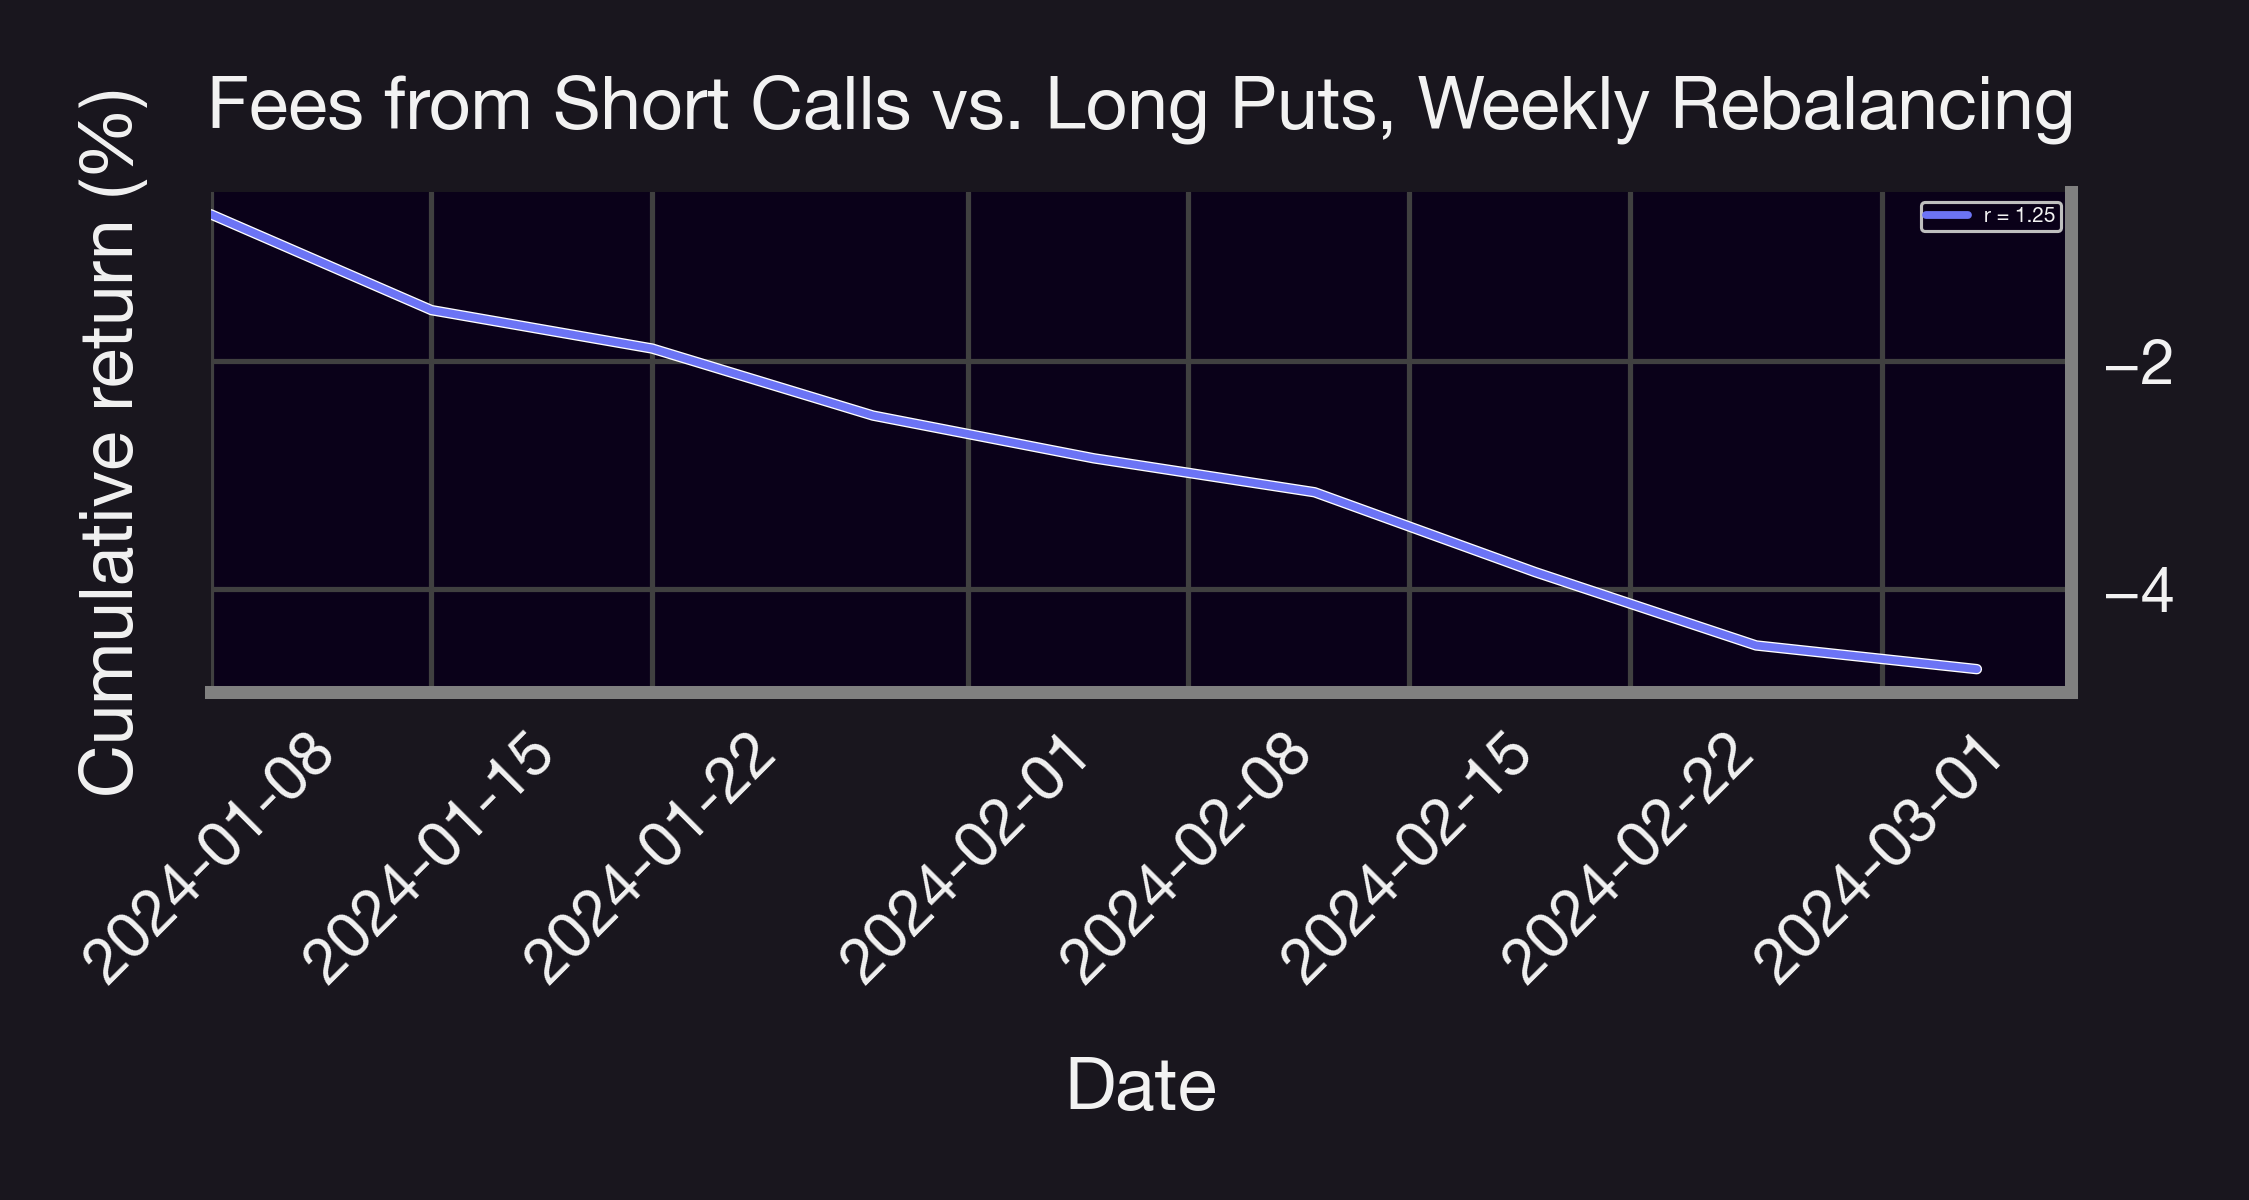

In [16]:
'''Cumulative Returns'''
rets = {}
for strat, period in strategies.items():
     if 'a' in period or 'd' in period:
          rets[strat_label_2(strat)] = strat.daily_fees['fees_perc']
     if 'a' in period or 'w' in period:
          rets[strat_label_2(strat)] = strat.weekly_fees['fees_perc']
     if 'a' in period or 'm' in period:
          rets[strat_label_2(strat)] = strat.monthly_fees['fees_perc']

# Plot rebalancing strategies
plot_cum_rets(rets = rets,
     xlabel = 'Date',
     ylabel = 'Cumulative return (%)',
     title = f'Fees from {pool_strategy}, {reb_period} Rebalancing',
     dir = f"{strat.raw_dir}cum_fees_FULL",
     label=False
)

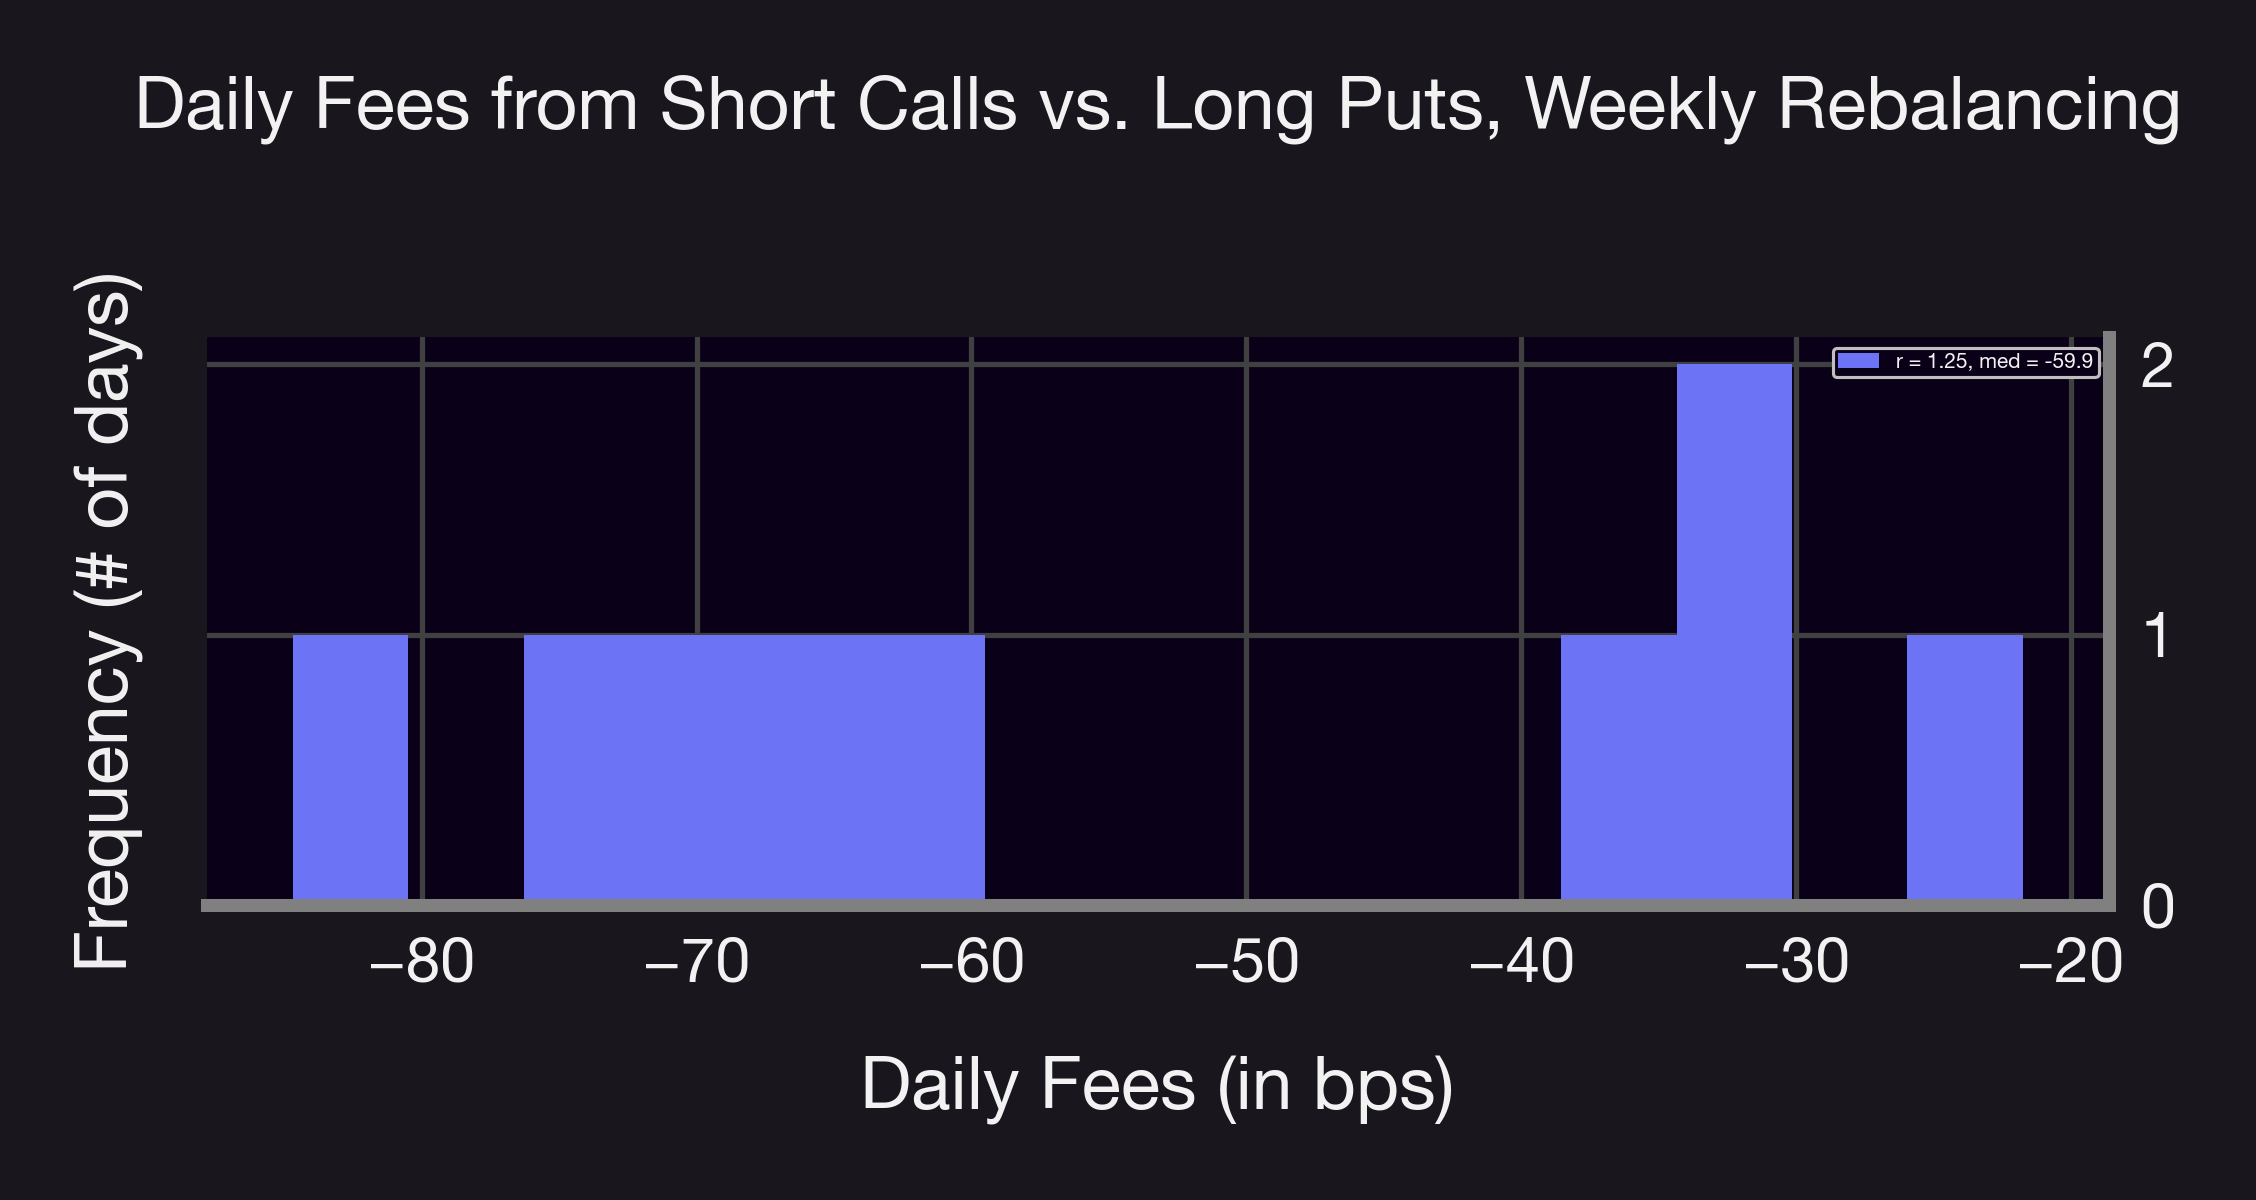

In [17]:
'''Plot all histograms at once'''
rets = {}
BPS = 10_000

for strat, period in strategies.items():
     if 'a' in period or 'd' in period:
          rets[strat_label_2(strat)] = strat.daily_fees['fees_perc'] * BPS
     if 'a' in period or 'w' in period:
          rets[strat_label_2(strat)] = strat.weekly_fees['fees_perc'] * BPS
     if 'a' in period or 'm' in period:
          rets[strat_label_2(strat)] = strat.monthly_fees['fees_perc'] * BPS

# Plot rebalancing strategies
plot_hist_all(rets = rets,
          xlabel = 'Daily Fees (in bps)',
          ylabel = 'Frequency (# of days)',
          title = f'Daily Fees from {pool_strategy}, {reb_period} Rebalancing',
          dir = f"{strat.raw_dir}/hist_fees_FULL",
          bins = 15,
)

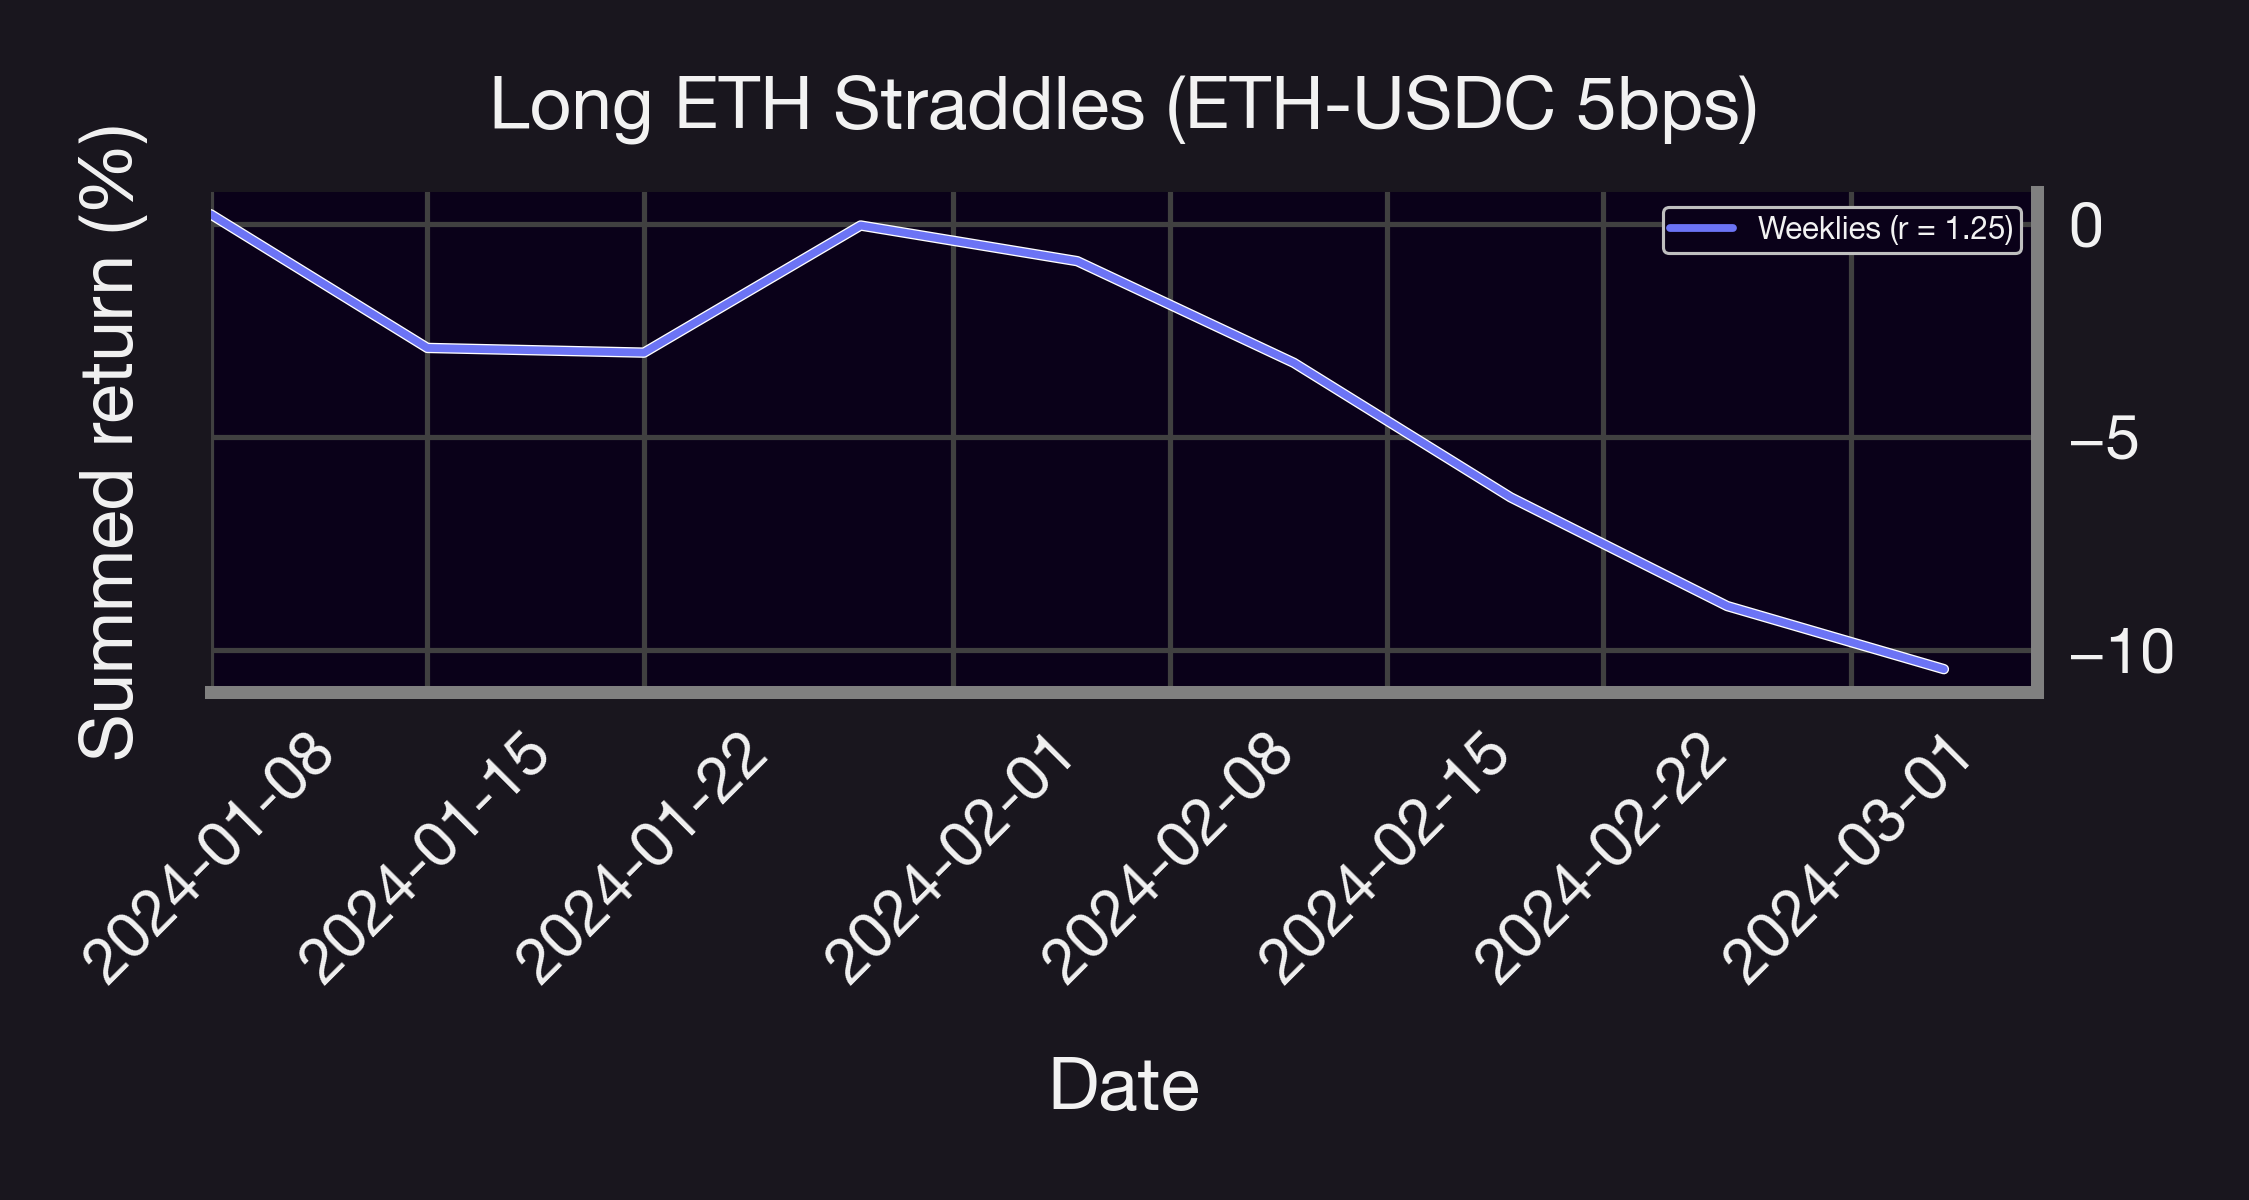

In [18]:
'''Summed Returns'''
rets = {}
for strat, period in strategies.items():
     if 'a' in period or 'd' in period:
          rets[f"Dailies ({strat_label_2(strat)})"] = strat.daily_pos['pnl_perc'] \
                                       + strat.daily_fees['fees_perc']
     if 'a' in period or 'w' in period:
          rets[f"Weeklies ({strat_label_2(strat)})"] = strat.weekly_pos['pnl_perc'] \
                                       + strat.weekly_fees['fees_perc']
     if 'a' in period or 'm' in period:
          rets[f"Monthlies ({strat_label_2(strat)})"] = strat.monthly_pos['pnl_perc'] \
                                       + strat.monthly_fees['fees_perc']

# Plot rebalancing strategies
plot_summed_rets(rets = rets,
     xlabel = 'Date',
     ylabel = 'Summed return (%)',
     title = 'Long ETH Straddles (ETH-USDC 5bps)',
     dir = f"{strat.raw_dir}summed_rets_FULL_2",
     label = False
)

In [20]:
# Daily Fees summary stats
print("FEES (bps): \n")
for strat in strategies:
    print(strat_name(strat))
    fees_stats = pd.DataFrame(strat_summary(strat.daily_fees['fees_perc']), columns=['Daily'])
    fees_stats['Weekly'] = strat_summary(strat.weekly_fees['fees_perc'])
    fees_stats['Monthly'] = strat_summary(strat.monthly_fees['fees_perc'])
    print(fees_stats, '\n')
    fees_stats.to_csv(f"{strat.raw_dir}{strat_file(strat)}_fees.csv")

FEES (bps): 

(USDC-ETH 30 bps, 2024-01-01 - 2024-02-28, r = 1.25)


NameError: name 'strat_summary' is not defined